In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
import xgboost as xgb
import matplotlib
import torch
import torch.utils.data as data_utils
import torch.nn as nn
import tensorflow as tf

In [2]:
date='16Mar2021'
dir_name='/preprocessing/200PU_2806'
workdir=os.getcwd()
files_dir='/data_cms_upgrade/hakimi'
os.makedirs(workdir+dir_name, exist_ok=True)
data_dir=workdir+dir_name

In [3]:
%%time
columns=['genpart_exeta',
         'genpart_pt',
 'cl3d_pt',
 'cl3d_eta',
 'cl3d_showerlength',
 'cl3d_coreshowerlength',
 'cl3d_firstlayer',
 'cl3d_maxlayer',
 'cl3d_seetot',
 'cl3d_seemax',
 'cl3d_spptot',
 'cl3d_sppmax',
 'cl3d_szz',
 'cl3d_srrtot',
 'cl3d_srrmax',
 'cl3d_srrmean',
 'cl3d_emaxe',
 'cl3d_hoe',
 'cl3d_meanz',
 'cl3d_layer10',
 'cl3d_layer50',
 'cl3d_layer90',
 'cl3d_ntc67',
 'cl3d_ntc90',
 'layer',
 'sample',
  'matches',
         
        ]
df= pd.read_csv(data_dir+'/cl3d.csv', usecols=columns, low_memory=True)

CPU times: user 15.5 s, sys: 3.41 s, total: 18.9 s
Wall time: 19 s


<string>:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
df['genpart_exeta'][df['sample']=='PU']=0
df['genpart_pt'][df['sample']=='PU']=0
df['matches'][df['sample']=='PU']=0

/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel pac

In [5]:
df['genpart_pt'][df['sample']=='PU'].min()

0.0

In [6]:
for samp in ['elec', 'pion', 'PU']:
    print(samp,len(df[df['sample']==samp]))

elec 279928
pion 9545
PU 29757


# Config

In [7]:
genptcut=20
cl3dptcut=5
PU_cut = 20
etamin=1.6
etamax=2.9
bkg='PU' # 'pions' or 'PU'
standardize = "_unstandardized"
feature_set=1 # 1: baseline 4: minimal, 10-13 + new vars (12 -> PU 13-> pions)
opti=False
res_dir=workdir+'/res/res_pt{}_vs{}_featset{}{}'.format(genptcut, bkg, feature_set, standardize)
os.makedirs(res_dir, exist_ok=True)

In [8]:
%%time
#cut
algo_cut={}

def tolist(x):
    if x.matches==True:
        x.test=x.layer[1:-1].split(',')
    else: x.test=np.nan
    return x.test
print(len(df))

#cut on pt gen level for electrons and pions
sel=((df['genpart_pt']>genptcut) & (df['sample']!='PU')) | (df['sample']=='PU')
df_cut=df[sel]

#cut on cl3d_pt for elec and pions
sel=((df['cl3d_pt'] > cl3dptcut) & (df['sample']!='PU')) | (df['sample']=='PU')
df_cut=df[sel]
print('elec and pions pt cut :',len(df_cut), len(df_cut[df_cut['sample']=='elec']))

#cut on cl3d_pt for PU
sel=((df_cut['cl3d_pt'] > PU_cut) & (df_cut['sample']=='PU')) | (df_cut['sample']!='PU')
df_cut=df_cut[sel]
print('PU pt cut :',len(df_cut), len(df_cut[df_cut['sample']=='elec']))

#cut on hgcal eta acceptance
sel=np.abs(df_cut['genpart_exeta'])>etamin
df_cut=df_cut[sel]
print('min eta cut :',len(df_cut), len(df_cut[df_cut['sample']=='elec']))
sel=np.abs(df_cut['genpart_exeta'])<etamax
df_cut=df_cut[sel]
print('max eta cut : ',len(df_cut), len(df_cut[df_cut['sample']=='elec']))
#drop incomplete events
df_cut.dropna(inplace=True)
print('drpna : ', len(df_cut))

#cut on cl3deta
df_cut['abseta']=np.abs(df_cut['cl3d_eta'])
sel=(df_cut['abseta']>etamin) & (df_cut['abseta']<etamax)
df_cut=df_cut[sel]
print('cl3d eta cut:', len(df_cut), len(df_cut[df_cut['sample']=='elec']))

#layer_pt preproc
df_cut['layer_pt']=df_cut.apply(tolist, axis=1)
df_cut.drop('layer', axis=1, inplace=True)
print("done")
def layering (x):
    return float(x.layer_pt[n])

##besoin de créer une variable par layer?
algo_layer={}
n_layers=len(df_cut['layer_pt'].iloc[0])
#print(n_layers)
layer_columns=[]

for n in range(n_layers):
    print('layering: {}/{}\r'.format(n+1,n_layers),end='', flush=True)
    df_cut['layer_{}'.format(n)]=df_cut.apply(layering, axis=1)
    layer_columns.append('layer_{}'.format(n))
print("done layering")
"""if feature_set in [6]:
    for n in range(n_layers):
        print('layering: {}/{}\r'.format(n+1,n_layers),end='', flush=True)
        df_cut['layer_{}'.format(n)]=df_cut.apply(layering, axis=1)
        df_cut['layer_{}'.format(n)] = df_cut['layer_{}'.format(n)]/df_cut['cl3d_pt']
        layer_columns.append('layer_{}'.format(n))
    print("done layering")"""

319230
elec and pions pt cut : 314710 275772
PU pt cut : 314710 275772
min eta cut : 264678 256235
max eta cut :  232315 225066
drpna :  232315
cl3d eta cut: 231661 224441
done
done layering36
CPU times: user 2min 58s, sys: 14.3 s, total: 3min 12s
Wall time: 3min 13s


In [9]:
# build new vars

#abseta
df_cut['abseta']=np.abs(df_cut['cl3d_eta'])

#variance
df_cut['varee']=df_cut['cl3d_seetot']**2
df_cut['varpp']=df_cut['cl3d_spptot']**2
df_cut['varzz']=df_cut['cl3d_szz']**2
df_cut['varrr']=df_cut['cl3d_srrtot']**2

#EoT: pt(Ecal)/pt(Tot)
nLayerEcal= 14
sumE=0

sumT=0
for i in range(n_layers):
    #print('Totlayer_{}'.format(i))
    sumT+=df_cut['layer_{}'.format(i)]
    
    
for i in range(1,nLayerEcal+1):
    #print('Ecal layer_{}'.format(i))
    sumE+=df_cut['layer_{}'.format(i)]
df_cut['EoT']=sumE/sumT

#fraction of pt in first x  layers and last x layers
maxfirst = 5
maxlast=10

for n in range(1,maxfirst+1):
    Sum=0
    for i in range(1,n+1):
        Sum+=df_cut['layer_{}'.format(i)]
    df_cut['first_{}'.format(n)]= Sum/sumT
    
for n in range(1,maxlast):
    Sum=0
    #print(n, ' layers')
    for i in range(n_layers - n, n_layers):
        #print(n,i)
        Sum+=df_cut['layer_{}'.format(i)]
    #print('last_{}'.format(n), sum/sumT)
    df_cut['last_{}'.format(n)]= Sum/sumT
    
    

for n in range(1,maxfirst+1):
    Sum=0
    for i in range(1,n+1):
        #print('layer_{}'.format(nLayerEcal+i))
        Sum+=df_cut['layer_{}'.format(nLayerEcal+i)]
    df_cut['firstHcal_{}'.format(n)]= Sum/sumT
    
    
# Emaxx : pt in x layers around Elec max layer (5)
maxpos=5

#print('emax_1')
Sum=0
Sum+=df_cut['layer_{}'.format(maxpos)]
df_cut['Emax_1']=Sum/sumT
 
#print('emax_2L')
Sum=0
for i in range(maxpos-1, maxpos+1):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_2G']=Sum/sumT
    
#print('emax_2R')
Sum=0
for i in range(maxpos, maxpos+2):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_2R']=Sum/sumT
    
#print('emax_3')
Sum=0
for i in range(maxpos-1, maxpos+2):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_3']=Sum/sumT
#print('emax_4G')
Sum=0
for i in range(maxpos-2, maxpos+2):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_4L']=Sum/sumT
#print('emax_4R')
Sum=0
for i in range(maxpos-1, maxpos+3):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_4R']=Sum/sumT
#print('emax_5')
Sum=0
for i in range(maxpos-2, maxpos+3):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_5']=Sum/sumT
    
    
    

In [10]:
%%time
#do bitmaps with group
def ebm0(x):
    ebm=[]
    thr=0
    for i in range(1,nLayerEcal+1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def ebm1(x):
    ebm=[]
    thr=1
    for i in range(1,nLayerEcal+1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def hbm(x):
    ebm=[]
    thr=1
    for i in range(nLayerEcal+1,n_layers):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
        
df_cut['ebm0']=df_cut.apply(ebm0, axis=1)
df_cut['ebm1']=df_cut.apply(ebm1, axis=1)
df_cut['hbm']=df_cut.apply(hbm, axis=1)

CPU times: user 2min 53s, sys: 6.08 s, total: 2min 59s
Wall time: 2min 55s


In [11]:
%%time
#do bitmaps with group
def reverse_ebm0(x):
    ebm=[]
    thr=0
    for i in range(1,nLayerEcal+1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def reverse_ebm1(x):
    ebm=[]
    thr=1
    for i in range(1,nLayerEcal+1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def reverse_hbm(x):
    ebm=[]
    thr=1
    for i in range(nLayerEcal+1,n_layers):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
        
df_cut['reverse_ebm0']=df_cut.apply(reverse_ebm0, axis=1)
df_cut['reverse_ebm1']=df_cut.apply(reverse_ebm1, axis=1)
df_cut['reverse_hbm']=df_cut.apply(reverse_hbm, axis=1)
print('done')

done
CPU times: user 2min 55s, sys: 6.07 s, total: 3min 1s
Wall time: 2min 57s


In [12]:
# quantization

def quantize(feat, nbits, method): #feat is the feature to quantize, nbist the number of bits, method: 'uniform' or 'percentile'
    nbins= 2**nbits
    fmin=feat.min()
    fmax=feat.max()
    if method == 'uniform':
        bins=np.linspace(fmin, fmax, nbins+1)
    elif method == 'percentile':
        bins=[np.percentile(feat, n) for n in np.linspace(0,100,nbins+1)]
    else :
        print('Error: Invalid method')
        return
    
    
    
    return np.digitize(feat, bins)

In [23]:
print(df_cut.columns.tolist())

['genpart_exeta', 'genpart_pt', 'cl3d_pt', 'cl3d_eta', 'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot', 'cl3d_sppmax', 'cl3d_szz', 'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean', 'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'matches', 'sample', 'abseta', 'layer_pt', 'layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_8', 'layer_9', 'layer_10', 'layer_11', 'layer_12', 'layer_13', 'layer_14', 'layer_15', 'layer_16', 'layer_17', 'layer_18', 'layer_19', 'layer_20', 'layer_21', 'layer_22', 'layer_23', 'layer_24', 'layer_25', 'layer_26', 'layer_27', 'layer_28', 'layer_29', 'layer_30', 'layer_31', 'layer_32', 'layer_33', 'layer_34', 'layer_35', 'varee', 'varpp', 'varzz', 'varrr', 'EoT', 'first_1', 'first_2', 'first_3', 'first_4', 'first_5', 'last_1', 'last_2', 'last_3', 'last_4', 'last_5', 'last_6', 'last_

In [24]:
#plot features distrib
plot= False
if plot:
    var_list= ['cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer',
           'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_spptot',
           'cl3d_szz', 'cl3d_srrtot',
           'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50',
           'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 
           'abseta', 'varee', 'varpp', 'varzz', 'varrr', 'EoT', 'first_1', 'first_2',
            'first_3', 'first_4', 'first_5', 'last_1', 'last_2', 'last_3', 'last_4',
            'last_5', 'last_6', 'last_7', 'last_8', 'last_9', 'firstHcal_1', 'firstHcal_2',
            'firstHcal_3', 'firstHcal_4', 'firstHcal_5', 'Emax_1', 'Emax_2G', 'Emax_2R', 'Emax_3',
            'Emax_4L', 'Emax_4R', 'Emax_5', 'ebm0', 'ebm1', 'hbm', 'reverse_ebm0', 'reverse_ebm1', 'reverse_hbm']

    nbins=100
    binmin=[1, 1, 1, 1, 0, 0, 0.0, 0.0, 0., -1.0, 328.15726, 0., 1.5, 4.004325, 0.67, 0.9, 1.6, 0, 0, 0.0, 0.0,
     0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,0,0,0,0,0,0]
    binmax=[50.0, 36.0, 34.0, 50.0, 0.09, 0.075, 90, 0.01, 1, 5, 500, 36, 36, 36, 80, 200, 2.9, 0.007,
         0.005, 800, 0.0001, 1.0, 0.01, 0.03, 0.15, 0.5, 0.5,0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 
            0.3, 0.3,0.4, 0.6, 0.6,0.25,0.62,0.9]
    
    os.makedirs(workdir + '/distrib', exist_ok=True)
    for i,feat in enumerate(var_list):
        if i in [0,1,2,3]:
            nbins=36
        else: nbins= 100
        #print(feat, binmin[i], binmax[i])
        bins=np.linspace(binmin[i],binmax[i],nbins)
        plt.figure(figsize=(12,7))
        plt.hist(df_cut[feat][df_cut['sample']=='elec'], bins=bins, label='elec', density=True, histtype='step')
        plt.hist(df_cut[feat][df_cut['sample']=='pion'],bins=bins, label='pions', density=True, histtype='step')
        plt.hist(df_cut[feat][df_cut['sample']=='PU'],bins=bins, label='PU', density=True, histtype='step')
        plt.title("{} distribution ".format(feat))
        #plt.yscale('log')
        #plt.xlim(0,36)
        plt.legend()

        plt.savefig(workdir+'/distrib/{}.png'.format(feat))

In [25]:
# plot longitudinal profile: mean fraction of elec pt / layer
frac={}
for n in range(n_layers):
    frac[n]=df_cut[df_cut['sample']=="elec"]['layer_{}'.format(n)]/df_cut[df_cut['sample']=="elec"]['cl3d_pt']

In [26]:
meanfrac=[frac[n].mean() for n in range(n_layers)]

<BarContainer object of 36 artists>

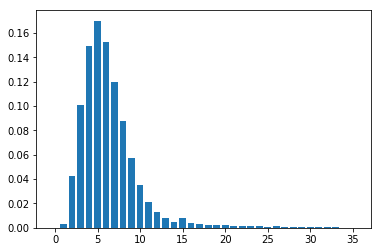

In [27]:
plt.bar(range(n_layers),meanfrac)

In [28]:
"""
from sklearn.model_selection import train_test_split


if feature_set == 1:
    features=['cl3d_showerlength', 
       'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_szz',
       'cl3d_seetot', 'cl3d_spptot', 'cl3d_srrtot', 'cl3d_srrmean']
elif feature_set ==2:
    features=[ 'cl3d_showerlength',
       'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_szz',
       'cl3d_seetot', 'cl3d_spptot', 'cl3d_srrtot', 'cl3d_srrmean', 'cl3d_layer10',
        'cl3d_layer50','cl3d_layer90','cl3d_ntc67','cl3d_ntc90', 'cl3d_hoe','cl3d_meanz',
        'cl3d_emaxe' ]
elif feature_set ==3:
    features = [ 'cl3d_showerlength',
       'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_szz',
       'cl3d_seetot', 'cl3d_spptot', 'cl3d_srrtot', 'cl3d_srrmean', 'cl3d_layer10',
        'cl3d_layer50','cl3d_layer90','cl3d_ntc67','cl3d_ntc90', 'cl3d_hoe','cl3d_meanz',
        'cl3d_emaxe' ]
    features=features+layer_columns
elif feature_set== 4:
    features=[ 'cl3d_seetot', 'cl3d_spptot', 'cl3d_srrtot', 'cl3d_srrmean', 'cl3d_hoe','cl3d_meanz',
        'cl3d_emaxe','cl3d_ntc67','cl3d_ntc90',]
    features=features+layer_columns
elif feature_set==5:
    features=['cl3d_showerlength',
 'cl3d_coreshowerlength',
 'cl3d_firstlayer',
 'cl3d_maxlayer',
 'cl3d_seetot',
 'cl3d_seemax',
 'cl3d_spptot',
 'cl3d_sppmax',
 'cl3d_szz',
 'cl3d_srrtot',
 'cl3d_srrmax',
 'cl3d_srrmean',
 'cl3d_emaxe',
 'cl3d_hoe',
 'cl3d_meanz',
 'cl3d_layer10',
 'cl3d_layer50',
 'cl3d_layer90',
 'cl3d_ntc67',
 'cl3d_ntc90']
    
elif feature_set ==6:
    features = ['cl3d_showerlength',
       'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_szz',
       'cl3d_seetot', 'cl3d_spptot', 'cl3d_srrtot', 'cl3d_srrmean', 'cl3d_layer10',
        'cl3d_layer50','cl3d_layer90','cl3d_ntc67','cl3d_ntc90', 'cl3d_hoe','cl3d_meanz',
        'cl3d_emaxe' ]
    features=features+layer_columns
elif feature_set ==7:
    features = [ 'cl3d_showerlength',
       'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_szz',
       'cl3d_seetot', 'cl3d_spptot', 'cl3d_srrtot', 'cl3d_srrmean', 'cl3d_layer10',
        'cl3d_layer50','cl3d_layer90','cl3d_ntc67','cl3d_ntc90', 'cl3d_hoe','cl3d_meanz',
        'cl3d_emaxe', 'cl3d_eta' ]
    features=features+layer_columns
   
"""


"\nfrom sklearn.model_selection import train_test_split\n\n\nif feature_set == 1:\n    features=['cl3d_showerlength', \n       'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_szz',\n       'cl3d_seetot', 'cl3d_spptot', 'cl3d_srrtot', 'cl3d_srrmean']\nelif feature_set ==2:\n    features=[ 'cl3d_showerlength',\n       'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_szz',\n       'cl3d_seetot', 'cl3d_spptot', 'cl3d_srrtot', 'cl3d_srrmean', 'cl3d_layer10',\n        'cl3d_layer50','cl3d_layer90','cl3d_ntc67','cl3d_ntc90', 'cl3d_hoe','cl3d_meanz',\n        'cl3d_emaxe' ]\nelif feature_set ==3:\n    features = [ 'cl3d_showerlength',\n       'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_szz',\n       'cl3d_seetot', 'cl3d_spptot', 'cl3d_srrtot', 'cl3d_srrmean', 'cl3d_layer10',\n        'cl3d_layer50','cl3d_layer90','cl3d_ntc67','cl3d_ntc90', 'cl3d_hoe','cl3d_meanz',\n        'cl3d_emaxe' ]\n    features=features+layer_columns\nelif feat

In [ ]:
from sklearn.model_selection import train_test_split

if feature_set == 1:
    name = 'minimal w/ var'
    features = ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                'cl3d_meanz','cl3d_showerlength','cl3d_coreshowerlength'] #hoe/maxlayer
if feature_set == 2:
    name = 'baseline w/ var'
    features =  ['cl3d_showerlength','cl3d_coreshowerlength','cl3d_firstlayer','cl3d_maxlayer','varee', 'varzz',
    'varpp', 'varrr',  'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50',
    'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'abseta']

if feature_set == 3:
    name = 'minimal w/ var & EoT'
    features = ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'EoT', 'cl3d_showerlength','cl3d_coreshowerlength'] #hoe/maxlayer

if feature_set == 4:
    name = 'minimal w/ var & EoT & layervar & bitmap '
    features = ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz','cl3d_showerlength','cl3d_coreshowerlength', 'EoT', 'first_1', 'first_2', 'first_3', 'first_4', 'first_5', 'last_1',
       'last_2', 'last_3', 'last_4', 'last_5', 'last_6', 'last_7', 'last_8',
       'last_9', 'firstHcal_1', 'firstHcal_2', 'firstHcal_3', 'firstHcal_4',
       'firstHcal_5', 'firstHcal_6', 'Emax_1', 'Emax_2','Emax_3', 'ebm0', 'ebm1', 'hbm', 'reverse_ebm0', 'reverse_ebm1', 'reverse_hbm']


if feature_set == 5:
    name = 'minimal w/ var & best pions '
    features = ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_showerlength','cl3d_coreshowerlength','EoT',
                'Emax_3', 'ebm1', 'first_4', 'first_5', 'first_3', 'Emax_2']
    
        
if feature_set == 6:
    name = 'minimal w/ var & best PU '
    features = ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_showerlength','cl3d_coreshowerlength', 'EoT',
                'firstHcal_6', 'Emax_3', 'ebm1', 'Emax_1', 'first_5', 'Emax_2']

In [ ]:
#chose signal and background
#weight calc

df_cut['signal']= 5
df_cut['weight']=0
df_cut['signal'][df_cut['sample']=='elec']= 1
df_cut['signal'][df_cut['sample']!='elec'] = 0

if bkg == 'pions':

    data=df_cut[df_cut['sample']!='PU']
    tot_event=len(data)
    sig_event=len(data[df['sample']=='elec'])
    bkg_event=len(data[df['sample']=='pion'])
    ws=tot_event/sig_event
    wb=tot_event/bkg_event
    #print(ws)
    data['weight'][data['signal']==0]=wb
    #print(np.unique(data['weight']))

    #print(wb)
    data['weight'][data['signal']==1]=ws
    #print(np.unique(data['weight']))

elif bkg == 'PU':
    data=df_cut[df_cut['sample']!='pions']
    tot_event=len(data)
    sig_event=len(data[df['sample']=='elec'])
    bkg_event=len(data[df['sample']=='PU'])
    ws=tot_event/sig_event
    wb=tot_event/bkg_event

    data['weight'][data['signal']==0]=wb
    data['weight'][data['signal']==1]=ws
print('signal weight = {}, bkg weight ={}'.format(ws, wb))

In [ ]:
#normalize features
from sklearn import preprocessing
import pickle
scaler = preprocessing.StandardScaler()
x=data[features]

for key in features:
        print(key, x[key].mean(), x[key].std())
if standardize==  "_Standardized":
    X=scaler.fit_transform(x)
else :X = x
pickle.dump(scaler, open(f"{res_dir}/scaler_model.pkl", "wb"))
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X, columns=features), data[['signal','weight','cl3d_eta','cl3d_pt', 'genpart_pt', 'genpart_exeta']], test_size=0.2,random_state=42)

train= xgb.DMatrix(data=X_train,label=y_train['signal'], feature_names=features, weight=y_train['weight'])
test= xgb.DMatrix(data=X_test,label=y_test['signal'],feature_names=features, weight=y_test['weight'])

#del(df_cut)

In [ ]:
X_test.columns

In [ ]:
%%time
opti=False
if opti ==True:
    param = {
        # Parameters that we are going to tune.
        'nthread':16,
        'max_depth':4,
        'eta':0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        # Other parameters
        'objective':'binary:logistic',
        'eval_metric': 'auc', 
    }


    #use gpu if available
    gpu=tf.test.is_gpu_available(
        cuda_only=False, min_cuda_compute_capability=None
    )
    if gpu==True:
        print('gpu available')
        param['tree_method']='gpu_hist'
    else: print('no gpu found')



    num_boost_round=200
    es_rounds=5
    #watchlist=
    progress={}

    metrics={'logloss','auc'} #last one used for es




    # grid search:
    gridsearch_params = [
        (max_depth, eta, l1, l2)
        for max_depth in [4,5,6,8]
        for eta in [0.01,0.05,0.1,0.2,0.3]
        for l1 in [0.01, 0.1,1,10] #alpha, def= 0
        for l2 in [0.01, 0.1,1,10] #lambda, def=1
    ]
    tot_iter=len(gridsearch_params)
    n_iter=0
    max_score = 0
    best_params = None
    for max_depth, eta, l1, l2 in gridsearch_params:
        n_iter+=1
        print("CV {}/{} with max_depth={}, eta={}, l1={}, l2={}".format(n_iter, tot_iter,
                                 max_depth, eta, l1, l2))
        # Update our parameters
        param['max_depth'] = max_depth
        param['eta'] = eta
        param['alpha']= l1
        param['lambda']=l2
        # Run CV
        cv_results = xgb.cv(
            param,
            train,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics={'auc'},
            early_stopping_rounds=es_rounds
        )
        # Update best MAE
        alpha=1
        mean_score = (cv_results['test-auc-mean']-alpha*abs(cv_results['test-auc-mean']-cv_results['train-auc-mean'])).max()
        boost_rounds = (cv_results['test-auc-mean']-alpha*abs(cv_results['test-auc-mean']-cv_results['train-auc-mean'])).argmax()
        print("\tScore {} in {} rounds".format(mean_score, boost_rounds))
        if mean_score > max_score:
            max_score = mean_score
            best_params = (max_depth,eta, l1, l2)
    print("Best params: {},  Score: {}".format(best_params, max_score))

In [ ]:
param = {
    'nthread' : 8,
    # Parameters that we are going to tune.
    'max_depth':4,
    'eta':0.2,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    # Other parameters
    'objective':'binary:logistic',
    'eval_metric': 'auc', 
    'alpha':10,
    'lambda':10,
}

#use gpu if available
gpu=tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)
if gpu==True:
    param['tree_method']='gpu_hist'

num_boost_round=200
es_rounds=5

metrics={'logloss','auc'} #last one used for es
# set up cross validation:
print('beginning cv')
cv_results = xgb.cv(
    param,
    train,
    num_boost_round=num_boost_round,
    seed=40,
    nfold=5,
    metrics=metrics,
    #feval=SoverB,
    early_stopping_rounds=es_rounds,
    shuffle=True,
    verbose_eval=2
)

## we define best score as the best test_auc penalized by the gap between train and test auc
alpha=1 #(penalization)

best_score=(cv_results['test-auc-mean']-alpha*abs(cv_results['test-auc-mean']-cv_results['train-auc-mean'])).max()
boost_rounds = (cv_results['test-auc-mean']-alpha*abs(cv_results['test-auc-mean']-cv_results['train-auc-mean'])).argmax()
print('best score:{} reached in {} rounds'.format(best_score, boost_rounds))


for metric in metrics:
    
    plt.figure(figsize=(12,7))
    x_axis=range(0,len(cv_results))
    plt.errorbar(x=x_axis,y=cv_results['train-{}-mean'.format(metric)],xerr=None, yerr=cv_results['train-{}-std'.format(metric)], label='Train')
    plt.errorbar(x=x_axis,y=cv_results['test-{}-mean'.format(metric)],xerr=None, yerr=cv_results['test-{}-std'.format(metric)], label='Test')
    plt.plot(boost_rounds, cv_results['test-{}-mean'.format(metric)][boost_rounds], 'b+', label='best', markersize=16)
    #plt.vlines(x=boost_rounds, ymin=0, ymax=cv_results['train-{}-mean'.format(metric)].max(), label='best score')
    plt.ylabel(metric)
    #plt.ylim(0.4,0.9)
    plt.xlabel('number of rounds')
    plt.legend()
    plt.savefig(res_dir+'/{}.png'.format(metric))

#plot ratio train/test
for metric in metrics:
    
    plt.figure(figsize=(12,7))
    x_axis=range(0,len(cv_results))
    ratio = (cv_results['train-{}-mean'.format(metric)]/cv_results['test-{}-mean'.format(metric)])
    plt.plot(ratio, label='ratio train/test')
    #plt.errorbar(x=x_axis,y=cv_results['test-{}-mean'.format(metric)],xerr=None, yerr=cv_results['test-{}-std'.format(metric)], label='Test')
    plt.plot(boost_rounds, ratio[boost_rounds], 'b+', label='best', markersize=16)
    #plt.vlines(x=boost_rounds, ymin=0, ymax=cv_results['train-{}-mean'.format(metric)].max(), label='best score')
    plt.ylabel(metric)
    #plt.ylim(0.8,1.2)
    plt.xlabel('number of rounds')
    plt.title('Ratio of train_{} / test_{}'.format(metric, metric))
    plt.legend()
    plt.savefig(res_dir+'/{}_ratio.png'.format(metric))

In [ ]:
#Now train and fit best parameters BDT



print('Training on {} events, signal : {}, bkg: {}'.format(len(y_train),len(y_train[y_train['signal']==1]),len(y_train[y_train['signal']==0])))
print('Testing on {} events, signal : {}, bkg: {}'.format(len(y_test),len(y_test[y_test['signal']==1]),len(y_test[y_test['signal']==0])))
eval_result = {}
BDT = xgb.train(
    param,
    train,
    num_boost_round=boost_rounds,
    #feval = SoverB,
    evals=[(train, 'Train'),(test, "Test")],
    evals_result = eval_result,
    verbose_eval=10,
)
BDT.save_model(res_dir+'/model.model')
print('model saved')
predictions_BDT_test=BDT.predict(test)
predictions_BDT_train=BDT.predict(train)
y_test['BDT']=predictions_BDT_test
#y_test['BDT_layer']=pred_PU_layer

#kolmogorov test 
from scipy import stats
ks_test_sig=stats.ks_2samp(predictions_BDT_test[y_test['signal']==1],predictions_BDT_train[y_train['signal']==1])
ks_test_bkg=stats.ks_2samp(predictions_BDT_test[y_test['signal']==0],predictions_BDT_train[y_train['signal']==0])
if ((ks_test_sig[1]>=0.05) & (ks_test_bkg[1]>=0.05)):  #pass test if pvalue > 5%
    print('KS test passed for sig: cannot distinguish the 2 distributions (pvalue ={})'.format(ks_test_sig[1]))
    print('KS test passed for bkg: cannot distinguish the 2 distributions (pvalue ={})'.format(ks_test_bkg[1]))
else: 
    print('KS test failed (pvalue ={}),Sig distributions are too different, check overtraining '.format(ks_test_sig[1]))
    print('KS test failed (pvalue ={}),Bkg distributions are too different, check overtraining '.format(ks_test_bkg[1]))
    

#plot AUC
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10,10))
fpr, tpr, threshold = roc_curve(y_test['signal'].astype('int32'),predictions_BDT_test, pos_label=1, sample_weight=y_test['weight'])
fpr.sort()
tpr.sort()
roc_auc_test = auc(fpr, tpr)
print ("AUC Score (Test): {:4%}".format(roc_auc_test))
plt.plot(tpr,fpr, label =' AUC test = %0.4f' %(roc_auc_test))

fpr, tpr, threshold = roc_curve(y_train['signal'].astype('int32'),predictions_BDT_train, pos_label=1, sample_weight=y_train['weight'])
fpr.sort()
tpr.sort()
roc_auc_train = auc(fpr, tpr)
print ("AUC Score (Test): {:4%}".format(roc_auc_train))
plt.plot(tpr,fpr, label =' AUC train = %0.4f' %(roc_auc_train))
plt.yscale('log')
plt.xlim(0.9,1.01)
#plt.ylim(0.6,1.05)
plt.xlabel('Signal efficiency')
plt.ylabel('Background efficiency')
plt.title('BDT ROC curve (log)')
plt.grid()
plt.legend()
plt.savefig(res_dir+'/ROC.png')
#plot BDT ouput by sample
plt.figure(figsize=(12,7))
x=[]
nbins=30
 
plt.hist(predictions_BDT_test[y_test['signal']==1],bins=np.linspace(0,1,nbins), label='test_signal', density=True, histtype='step', color='C0')
plt.hist(predictions_BDT_test[y_test['signal']==0],bins=np.linspace(0,1,nbins), label='test_bkg', density=True, histtype='step', color='C1')
plt.hist(predictions_BDT_train[y_train['signal']==1],bins=np.linspace(0,1,nbins), label='train_signal', density=True, histtype='step', linestyle='dashed', color='C0')
plt.hist(predictions_BDT_train[y_train['signal']==0],bins=np.linspace(0,1,nbins), label='train_bkg', density=True, histtype='step', linestyle='dashed', color='C1')
plt.xlabel('BDT output')
plt.ylabel('events')
plt.title('BDT output, ks sig pvalue = {:.3f}, ks bkg pvalue = {:.3f}'.format(ks_test_sig[1], ks_test_bkg[1]))
plt.legend(fontsize=12, loc = 'upper center')
plt.savefig(res_dir+'/BDToutput_trainvstest.png')

#plot importance
#importance
plt.figure(figsize=(15,10))
ax=plt.subplot(111)
xgb.plot_importance(BDT,ax,grid=False, importance_type='total_gain', show_values=False);
plt.savefig(res_dir+'/importance_totalgain.png')
    

# save config:
file_name=res_dir+'/BDTconfig.txt'
with open(file_name, 'w') as f:
    f.write('BDT config:   \n ')
    f.write('params = {} \n n_rounds= {} \n auc_train ={}\n auc_test={} \n ks_test_sig={} \n ks_test_bkg = {}'.format(param, boost_rounds, roc_auc_train, roc_auc_test, ks_test_sig, ks_test_bkg))
    f.write('input_list: {}\n'.format(features))
    f.write('Training on {} events, signal : {}, bkg: {}\n'.format(len(y_train),len(y_train[y_train['signal']==1]),len(y_train[y_train['signal']==0])))
    f.write('Testing on {} events, signal : {}, bkg: {}'.format(len(y_test),len(y_test[y_test['signal']==1]),len(y_test[y_test['signal']==0])))
    

In [ ]:
a

In [ ]:
# shap values
import shap
# select a set of background examples to take an expectation over
#background = X_train.to_numpy()[np.random.choice(X_train.shape[0], 1000, replace=False)]

# explain predictions of the model on four images
explainer = shap.Explainer(BDT)
a= X_test[(y_test['signal']==1).values].sample(1000)
b = X_test[(y_test['signal']==0).values].sample(1000)
shap_df= pd.concat([a,b])

#shap_values = explainer.shap_values(X_test.to_numpy()[np.random.choice(X_test.shape[0], 1000, replace=False)])
shap_values = explainer.shap_values(shap_df.to_numpy())

In [ ]:
# plot the feature attributions
#shap.image_plot(shap_values, -x_test[1:5])
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], features)

In [ ]:
col_names=[val[5:] for val in shap_df.columns if val != 'abseta']
col_names.append('abseta')


In [ ]:
shap_values

In [ ]:
shap_df

In [ ]:
bkg

In [ ]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
shap_df=pd.DataFrame(shap_values, columns=col_names)
shap_mean=[]
for column in shap_df.columns:
    shap_mean.append(np.abs(shap_df[column]).mean())
abs(shap_df).mean().sort_values().plot(kind='barh', figsize=(16,10))
plt.savefig(res_dir+'/importance_shap.png')

In [ ]:
matplotlib.rcParams.update({'font.size': 30})
plt.figure(figsize=(8,4))
#shap.summary_plot(shap_values, X_test.to_numpy()[np.random.choice(X_test.shape[0], 1000, replace=False)], 
#                  features,max_display=99, show=False, alpha = 0.7 )

shap.summary_plot(shap_values, shap_df.to_numpy() , col_names,max_display=99, show=False, alpha = 0.7 )
plt.xlabel('Shap value', fontsize=16)
plt.show()
plt.savefig(res_dir+'/importance_violin.pdf')

In [ ]:
shap_df.columns=col_names
explainer = shap.Explainer(BDT)
shap_values = explainer(shap_df, )

In [ ]:
shap.plots.beeswarm(shap_values, max_display=22)

In [ ]:
test=explainer.shap_values(shap_df)

In [ ]:
y_test['BDT']=predictions_BDT_test
#y_test['BDT_layer']=pred_PU_layer

plt.figure(figsize=(20,15))
score=[]
thr=0.95



#plot AUC
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10,10))
fpr, tpr, threshold = roc_curve(y_test['signal'].astype('int32'),predictions_BDT_test, pos_label=1,  sample_weight=y_test['weight'])
fpr.sort()
tpr.sort()
roc_auc_test = auc(fpr, tpr)
roc_test=pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})
roc_cut_test=roc_test[roc_test['tpr']>thr];
print ("AUC Score (Test): {:4%}".format(roc_auc_test))
plt.plot(tpr,(1-fpr), label =' AUC test = %0.4f' %(roc_auc_test))


fpr, tpr, threshold = roc_curve(y_train['signal'].astype('int32'),predictions_BDT_train, pos_label=1,sample_weight=y_train['weight'])
fpr.sort()
tpr.sort()
roc_auc_train = auc(fpr, tpr)
roc_auc_train = auc(fpr, tpr)
roc_train=pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})
roc_cut_train=roc_train[roc_train['tpr']>thr];
print ("AUC Score (Train): {:4%}".format(roc_auc_train))
plt.plot(tpr,(1-fpr), label =' AUC train = %0.4f' %(roc_auc_train))
plt.xlim(0.9,1.001)
plt.yscale('log')
plt.ylim(0.9,1.001)
plt.xlabel('Signal efficiency')
plt.ylabel('Background reduction')
plt.title('BDT ROC curve')
plt.axvline(x=thr, label='0.95 WP', c='k')
plt.grid()
plt.legend()
print('score  = {}%'.format(np.min(roc_cut_test['fpr'])*100))

In [ ]:
# calc BDT cut
thr=0.95
BDT_cut=np.interp(thr,roc_test['tpr'], roc_test['threshold'])
with open(file_name, 'a') as f:
    f.write('BDT cut ={}  for tpr = {} and fpr {}\n'.format( np.interp(thr,roc_test['tpr'], roc_test['threshold']), np.interp(0.95,roc_test['tpr'], roc_test['tpr']), np.interp(0.95,roc_test['tpr'], roc_test['fpr'])))

print('BDT cut ={}  for tpr = {} and fpr {}'.format( np.interp(thr,roc_test['tpr'], roc_test['threshold']),
                                                    np.interp(thr,roc_test['tpr'], roc_test['tpr']),
                                                    np.interp(thr,roc_test['tpr'], roc_test['fpr'])))

In [ ]:
#binning y_test


def calctp(group):
    pos=len(group[(group['BDT']>BDT_cut) & (group['signal']==1)])
    truepos= len(group[group['signal']==1])
    
    if truepos !=0 :return pos/truepos
    else : return np.nan
def calcfp(group):
    fp = len(group[(group['BDT']>BDT_cut) & (group['signal']==0)])
    trueneg = len(group[group['signal']==0])
    if trueneg !=0: return fp/trueneg
    else: return np.nan

In [ ]:

#CALCULATE ERROR BARS
conf_level=0.99
from scipy import stats
#normal
#def error(total, score, conf_level):
#    alpha=(1-conf_level)/2
#    sigma=np.sqrt(score*(1-score)/total)
#    delta=np.abs(score-stats.norm.ppf(1-alpha,loc=score, scale=sigma))
#    return delta

#clopper pearson
def error(total, score, conf_level):
    alpha=(1-conf_level)/2
    n=total
    k=score*n
    lo = score-stats.beta.ppf(alpha/2, k, n-k+1)
    hi = stats.beta.ppf(1 - alpha/2, k+1, n-k)-score
    return lo, hi


In [ ]:
pt_bins=[0,5,10,15,20,30,40,60,80,100,120,140,160,180,200,220]
eta_bins=[1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0]
pt_points=[2.5,7.5,12.5,17.5,25,35,50,70,90,110,130,150,170,190,210]
eta_points=[1.7,1.9,2.1,2.3,2.5,2.7,2.9]
y_test['BDT']=predictions_BDT_test

from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10,10))
fpr, tpr, threshold = roc_curve(y_test['signal'].astype('int32'),predictions_BDT_test, pos_label=1,  sample_weight=y_test['weight'])
fpr.sort()
tpr.sort()
roc_auc_test = auc(fpr, tpr)
roc_test=pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})
roc_cut_test=roc_test[roc_test['tpr']>thr];

conf_level=0.99


y_test['genpt_binned']=pd.cut(y_test['genpart_pt'], pt_bins)
group=y_test.groupby('genpt_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=lo,hi=error(y_test.groupby('genpt_binned').size(), tpr, conf_level)
plt.figure(figsize=(10,6))
plt.errorbar(pt_points, tpr.values, yerr=[lo,hi], label ='signal efficiency ({} conf level)'.format(conf_level))
plt.ylabel('signal efficiency')
plt.xlabel('gen pt (GeV)')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
plt.legend(loc='best')
plt.savefig(res_dir+'/sigeffvspt_WP{}.png'.format(thr))


y_test['cl3dpt_binned']=pd.cut(y_test['cl3d_pt'], pt_bins)
group=y_test.groupby('cl3dpt_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=lo,hi=error(y_test.groupby('cl3dpt_binned').size(), fpr, conf_level)
plt.figure(figsize=(10,6))
plt.errorbar(pt_points, fpr.values, yerr=[lo,hi], label ='bkg efficiency ({} conf level)'.format(conf_level))
plt.ylabel('bkg efficiency')
plt.xlabel('cluster pt (GeV)')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
plt.legend(loc='best')
plt.savefig(res_dir+'/bkgeffvspt_WP{}.png'.format(thr))


y_test['geneta_binned']=pd.cut(y_test['genpart_exeta'], eta_bins)
group=y_test.groupby('geneta_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=lo,hi=error(y_test.groupby('geneta_binned').size(), fpr, conf_level)
plt.figure(figsize=(10,6))
plt.errorbar(eta_points, tpr.values, yerr=[lo,hi], label ='signal efficiency ({} conf level)'.format(conf_level))
plt.ylabel('signal efficiency')
plt.xlabel('gen eta ')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
plt.legend(loc='best')
plt.savefig(res_dir+'/sigeffvseta_WP{}.png'.format(thr))


y_test['cl3deta_binned']=pd.cut(y_test['cl3d_eta'], eta_bins)
group=y_test.groupby('cl3deta_binned')
tpr = group.apply(calctp)
fpr= group.apply(calcfp)
lo,hi=lo,hi=error(y_test.groupby('cl3deta_binned').size(), fpr, conf_level)
plt.figure(figsize=(10,6))
plt.errorbar(eta_points, fpr.values, yerr=[lo,hi], label ='bkg efficiency ({} conf level)'.format(conf_level))
plt.ylabel('bkg efficiency')
plt.xlabel('cluster eta')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut))
plt.legend(loc='best')
plt.savefig(res_dir+'/bkgeffvseta_WP{}.png'.format(thr))


In [ ]:
y_test

In [ ]:
y_test.groupby('cl3dpt_binned').size()

#res pion BDT
AUC Score (Test): 99.770155%
AUC Score (Train): 99.903230%
background rejection test = 0.9882920110192837, train = 0.994824909435915
#res PU BDT
AUC Score (Test): 99.901765%
AUC Score (Train): 99.914897%
background rejection test = 0.9994748699879739, train = 0.9995563555778215

In [ ]:
BDT.predict(test)

In [ ]:
for bin in range(1,7):
    print(bin)